# A neural network that solves polynomials

## 0. Introduction

This post is based on [this](https://github.com/fchollet/keras/blob/master/examples/addition_rnn.py) wonderful example of a neural network that learns to add to given numbers. In the keras example, the inputs are numbers, however the network sees them as encoded characters. So, in effect, the network has no awareness of the inputs, specifically of their ordinal nature. And magically, it still learns to add the two input sequences (of numbers, which it sees as characters), and spits out the correct answer more often than not.

Here, my goal is to build on this (non-useful but cool) idea of formulating a math problem as a machine learning problem, and code up a Neural Network which learns to solve polynomials.

## 1. Formulating the problem

A polynomial is a mathematical function of the form:

$$f(x) = a_nx^n + \ldots + a_2x^2 + a_1x + a_0$$

There are no guarantees that such a function will have a root, i.e. there may be no $x$ values for which $f(x) = 0$. For our purposes, I will create a set of such polynomials for which there are roots. In fact, I will first create the roots, and then create the polynomials, as follows:

In [1]:
# First, let's make the dataset:

import numpy as np

np.random.RandomState = 2545

MIN_ROOT = -1
MAX_ROOT = 1

def make(n_samples, n_degree):
    global MIN_ROOT, MAX_ROOT
    y = np.random.uniform(MIN_ROOT, MAX_ROOT, (n_samples, n_degree))
    y.sort(axis=1)
    X = np.array([np.poly(_) for _ in y])
    return X, y

# toy case
X, y = make(1, 2)
print(X)
print(y)

[[ 1.         -0.22689484 -0.00127547]]
[[-0.00548864  0.23238348]]


Here in the toy example, I have a , we draw two random numbers between -1 and 1. The numbers drawn are  -0.00548864 and 0.23238348. Consequently, the polynomial that has those roots is produced by `numpy`'s `poly` function. Specifically,

$$f(x) = x^2  -0.22689484x -0.00127547 $$

becomes zero for $x = -0.00548864$ and $x = 0.23238348$. Note that because we selected 2 numbers the degree of the polynomial is 2 as well.

---

What I want to focus on in this toy dataset is, that a polynomial is represented as an ordered sequence of real numbers. It starts from the highest coefficient, and then the next coefficient, and then the next, and so on.. Not only the coefficients, but also the roots are represented as a sequence. They are sorted random numbers between -1 and 1. So, this is a `seq2seq` problem! `seq2seq` refers to the deep learning structures that take a sequence of things (usually words) as input, and spits out a sequence of things (usually the same "thing" as the input "thing").  

![](https://camo.githubusercontent.com/242210d7d0151cae91107ee63bff364a860db5dd/687474703a2f2f6936342e74696e797069632e636f6d2f333031333674652e706e67)

Generally, the use cases for `seq2seq` are NLP focused, such as question answering, translation between 2 languages and so on. In this example, our input sequence will be polynomial coefficients, and the output sequence will be the roots, in sorted order.

Note that there are pretty good numerical methods solving polynomials with given coefficients, which uses the companion matrix. See `numpy`'s [roots](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.roots.html#numpy.roots) function.

## 2. Let's go!

It is well known that polynomials of degree $>=5$ are not solvable by radicals. This was mathematically proved using Galois theory a long time ago. So, let's have our first network (numerically and approximately and probabilistically :) ) solve degree 5 polynomials.

In [2]:
# make and train test split
N_SAMPLES = 100000
DEGREE = 5
X_train, y_train = make(int(N_SAMPLES*0.8), DEGREE)
X_test, y_test = make(int(N_SAMPLES*0.2), DEGREE)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80000, 6) (80000, 5)
(20000, 6) (20000, 5)


In [3]:
# some dimensionality handling below
# this is because keras expects 3d tensors (a seq of onehot encoded characters) 
# but we have 2d tensors; just a sequence of numbers.


def reshape(array):
    return np.expand_dims(array, -1)
    
    
print(reshape(X_test).shape)  # batchsize, timesteps, input_dim (or "vocab_size")
print(reshape(y_test).shape) 

(20000, 6, 1)
(20000, 5, 1)


Now that the dataset is ready, let's create the model. We will have two recurrent layers, one as the encoder part and the other as the decoder part (see image above). I will use LSTM for the recurrent layers as it performs well more often than not. Note that this is seq2seq with un-shared weights.

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, Dense, TimeDistributed


hidden_size = 128
model = Sequential()

# ENCODER PART OF SEQ2SEQ
model.add(LSTM(hidden_size, input_shape=(DEGREE+1, 1)))

# DECODER PART OF SEQ2SEQ
model.add(RepeatVector(DEGREE))  # this determines the length of the output sequence
model.add((LSTM(hidden_size, return_sequences=True)))
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mae'])
print(model.summary())

Using TensorFlow backend.
/home/taylanbil/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
BATCH_SIZE = 128
model.fit(reshape(X_train),
          reshape(y_train),
          batch_size=BATCH_SIZE,
          epochs=5,
          verbose=1,
          validation_data=(reshape(X_test), 
                           reshape(y_test)))

Train on 80000 samples, validate on 20000 samples
Epoch 1/5
80000/80000 [==============================] - 19s 239us/step - loss: 0.1538 - mean_absolute_error: 0.1538 - val_loss: 0.1109 - val_mean_absolute_error: 0.1109
Epoch 2/5
80000/80000 [==============================] - 19s 232us/step - loss: 0.1066 - mean_absolute_error: 0.1066 - val_loss: 0.1064 - val_mean_absolute_error: 0.1064
Epoch 3/5
80000/80000 [==============================] - 18s 230us/step - loss: 0.0916 - mean_absolute_error: 0.0916 - val_loss: 0.0879 - val_mean_absolute_error: 0.0879
Epoch 4/5
80000/80000 [==============================] - 18s 230us/step - loss: 0.0788 - mean_absolute_error: 0.0788 - val_loss: 0.0794 - val_mean_absolute_error: 0.0794
Epoch 5/5
80000/80000 [==============================] - 18s 229us/step - loss: 0.0732 - mean_absolute_error: 0.0732 - val_loss: 0.0703 - val_mean_absolute_error: 0.0703


Mean Absolute Error is going down... that's great.  
This problem is a bit difficult to evaluate. Actually, so is almost all seq2seq problems.  

I am not aware of any standard way to evaluate the success of this model, so I got creative and thought of two ways of evaluating such a problem.  

1. Comparing the predicted roots to random guessing; i.e. for a given polynomial, we'll generate random numbers between -1 and 1 (as many as the DEGREE), sort them and look at the difference in absolute value between each pair (random, true root). We'll then do the same thing with each pair (predicted root, true root). Then we'll plot the histogram for such differences.
1. We'll generate random numbers as above, and evaluate the polynomial. We'll then evaluate the polynomial on the predicted roots. Then we'll do these evaluations for each polynomial and plot the histogram.

First, get the predictions and random roots.

In [6]:
y_pred = model.predict(reshape(X_test))
y_pred = np.squeeze(y_pred)

Now a function to help us compare, that we can re-use

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


def get_evals(polynomials, roots):
    evals = [
        [np.polyval(poly, r) for r in root_row]
        for (root_row, poly) in zip(roots, polynomials)
    ]
    evals = np.array(evals).ravel()
    return evals
    

def compare_to_random(y_pred, y_test, polynomials):
    y_random = np.random.uniform(MIN_ROOT, MAX_ROOT, y_test.shape)
    y_random.sort(axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax = axes[0]
    ax.hist(np.abs((y_random-y_test).ravel()), 
            alpha=.4, label='random guessing') 
    ax.hist(np.abs((y_pred-y_test).ravel()), 
            color='r', alpha=.4, label='model predictions')
    ax.set(title='Histogram of absolute errors',
           ylabel='count', xlabel='absolute error')
    ax.legend(loc='best')

    ax = axes[1]
    random_evals = get_evals(polynomials, y_random)
    predicted_evals = get_evals(polynomials, y_pred)
    pd.Series(random_evals).plot.kde(ax=ax, label='random guessing kde')
    pd.Series(predicted_evals).plot.kde(ax=ax, color='r', label='model prediction kde')
    title = 'Kernel Density Estimate plot\n' \
            'for polynomial evaluation of (predicted) roots'
    ax.set(xlim=[-.5, .5], title=title)
    ax.legend(loc='best')
    
    fig.tight_layout()

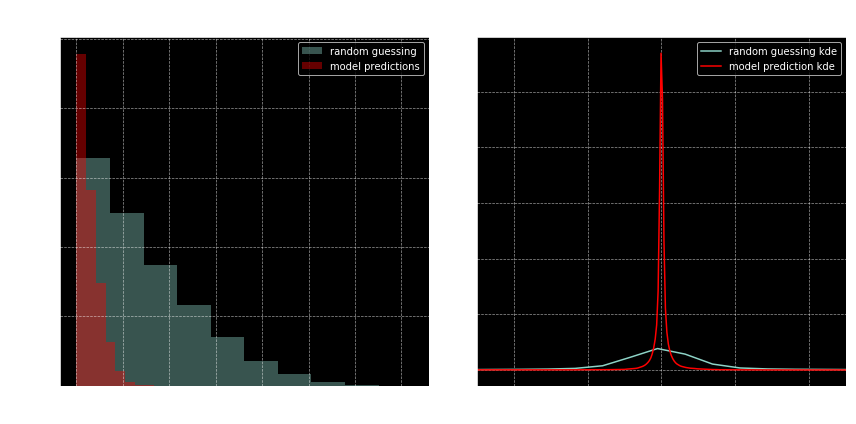

In [8]:
compare_to_random(y_pred, y_test, X_test)

These results look good to me! And this is after just 5 epochs!

On the left plot, notice how the predicted roots (red bars) are closer to the real roots (i.e. red bars are small after 0.25). On the right, notice how tight the red curve is around zero. That is, the expected distribution of the evaluation of polynomials at the model predicted roots is very tightly contained in the neighborhood of zero. At least there's a stark difference between that and e random evaluations.

---

Now I want to do something a bit more ambitious. I would like to modify the example above by removing the condition of solving degree 5 polynomials.

## 3. Solving polynomials of varying degree

This next example will solve polynomials of degree greater than 4 and less than 16. This is necessary since in the numerical techniques we employ, we need to give the network a maximum sequence length among other things.

First, let's create our datasets. We'll have 10k examples per degree. A couple of things to note:

* Every polynomial will be represented as a sequence of length 16. If for a given polynomial, the degree is less than 15, the sequence will be padded by zeros.
* The roots will be represented as TWO sequences of length 15. Specifically, it will be a 15x2 matrix. The first column will be the actual values of the roots, padded by 0. The second column is whether the root value was padded or not. Think of it as one-hot-encoding the EOS (end-of-sequence) character.


In [9]:
MAX_DEGREE = 15
MIN_DEGREE = 5
MAX_ROOT = 1
MIN_ROOT = -1
N_SAMPLES = 10000 * (MAX_DEGREE-MIN_DEGREE+1)


def make(n_samples, max_degree, min_degree, min_root, max_root):
    samples_per_degree = n_samples // (max_degree-min_degree+1)
    n_samples = samples_per_degree * (max_degree-min_degree+1)
    X = np.zeros((n_samples, max_degree+1))
    # XXX: filling the truth labels with ZERO??? EOS character would be nice
    y = np.zeros((n_samples, max_degree, 2))
    for i, degree in enumerate(range(min_degree, max_degree+1)):
        y_tmp = np.random.uniform(min_root, max_root, (samples_per_degree, degree))
        y_tmp.sort(axis=1)
        X_tmp = np.array([np.poly(_) for _ in y_tmp])
        
        root_slice_y = np.s_[
            i*samples_per_degree:(i+1)*samples_per_degree,
            :degree,
            0]
        pad_slice_y = np.s_[
            i*samples_per_degree:(i+1)*samples_per_degree,
            degree:,
            1]
        this_slice_X = np.s_[
            i*samples_per_degree:(i+1)*samples_per_degree,
            -degree-1:]
        
        y[root_slice_y] = y_tmp 
        y[pad_slice_y] = 1
        X[this_slice_X] = X_tmp
    return X, y

def make_this():
    global MAX_DEGREE, MIN_DEGREE, MAX_ROOT, MIN_ROOT, N_SAMPLES
    return make(N_SAMPLES, MAX_DEGREE, MIN_DEGREE, MIN_ROOT, MAX_ROOT)


from sklearn.model_selection import train_test_split
X, y = make_this()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


print('X shapes', X.shape, X_train.shape, X_test.shape)
print('y shapes', y.shape, y_train.shape, y_test.shape)
print('-'*80)
print('This is an example root sequence')
print(y[0])

X shapes (110000, 16) (82500, 16) (27500, 16)
y shapes (110000, 15, 2) (82500, 15, 2) (27500, 15, 2)
--------------------------------------------------------------------------------
This is an example root sequence
[[-0.88054536  0.        ]
 [-0.63814698  0.        ]
 [-0.20252743  0.        ]
 [-0.12429279  0.        ]
 [ 0.75713038  0.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]]


Let's explain this last part;

* What you see as the example sequence above representing roots for a polynomial, is a 15x2 matrix.  
* Second column has 0s and 1s. When it is a zero, the first column will contain an actual root value.
* When the second column is 1, the first column will have a 0 (as the pad value). This means that row is there as padding.

---

Here's the model. Exactly the same structure, only the dimensions are changed. 

In [10]:
hidden_size = 128
model = Sequential()

model.add(LSTM(hidden_size, input_shape=(MAX_DEGREE+1, 1)))
model.add(RepeatVector(MAX_DEGREE))
model.add((LSTM(hidden_size, return_sequences=True)))
model.add(TimeDistributed(Dense(2)))

model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mae'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 15, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 2)             258       
Total params: 198,402
Trainable params: 198,402
Non-trainable params: 0
_________________________________________________________________
None


Here's a neat trick to quickly see if the layers in the model is set up in a compatible way with the dimensions of the inputs: Before fitting the model, just predict using the test set. If the input tensor flows through it fine, without errors, then the model is good to go.

In [11]:
model.predict(reshape(X_test));  # this last semi-column will suppress the output.

Now let's fit our model. This time I'll train it for 10 epochs.

In [12]:
BATCH_SIZE = 12
model.fit(reshape(X_train), y_train,
          batch_size=BATCH_SIZE,
          epochs=10,
          verbose=1,
          validation_data=(reshape(X_test), y_test))

Train on 82500 samples, validate on 27500 samples
Epoch 1/10
82500/82500 [==============================] - 147s 2ms/step - loss: 0.0473 - mean_absolute_error: 0.0473 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 2/10
82500/82500 [==============================] - 145s 2ms/step - loss: 0.0290 - mean_absolute_error: 0.0290 - val_loss: 0.0255 - val_mean_absolute_error: 0.0255
Epoch 3/10
82500/82500 [==============================] - 138s 2ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - val_loss: 0.0258 - val_mean_absolute_error: 0.0258
Epoch 4/10
82500/82500 [==============================] - 133s 2ms/step - loss: 0.0248 - mean_absolute_error: 0.0248 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 5/10
82500/82500 [==============================] - 132s 2ms/step - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 6/10
82500/82500 [==============================] - 131s 2ms/step - loss: 0.0218 - mean_absolu

Now there's one more issue that the varying degree requirement has introduced. Look at what happens when we predict the roots of a polynomial; specifically, check out the second column.

In [13]:
model.predict(reshape(X[100:101]))

array([[[ -3.32482040e-01,   1.54696405e-04],
        [ -5.75829819e-02,  -2.86698341e-05],
        [  1.54504657e-01,   8.33250582e-04],
        [  3.24361920e-01,   1.10552460e-03],
        [  5.12778938e-01,   1.41113997e-05],
        [ -2.66120583e-03,   1.00157547e+00],
        [ -3.35310400e-03,   1.00074172e+00],
        [ -3.01474333e-03,   1.00066710e+00],
        [ -3.09853256e-03,   1.00048482e+00],
        [ -2.91807204e-03,   1.00058520e+00],
        [ -3.08198482e-03,   1.00052881e+00],
        [ -2.97554582e-03,   1.00074744e+00],
        [ -3.03085148e-03,   1.00064242e+00],
        [ -2.96967477e-03,   1.00064325e+00],
        [ -2.97010690e-03,   1.00057983e+00]]], dtype=float32)

As we see, the network spits out a bunch of very small numbers, followed by a bunch of numbers that are very close to 1. This is expected behavior for the people familiar with the inner workings of a neural network. However, we're not interested in this, we want a cutoff threshold and essentially map the second column into 0s and 1s, and we want the root values corresponding to the non-padded rows (i.e. where the second column is 0). To that end, let's quickly analyze the distribution of the second columns throughout the predictions.

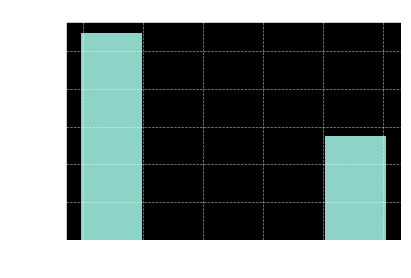

In [14]:
y_pred = model.predict(reshape(X_test))
pad_or_not = y_pred[:, :, 1].ravel()
fig, ax = plt.subplots()
ax.set(title='histogram for predicting PAD',
       xlabel='predicted value',
       ylabel='count')
ax.hist(pad_or_not, bins=5);

Looks like the values would be descritized without any issues if we chose the threshold value of 0.5

---

Now I would like to look at the cases where the network did not get the number of roots correctly. The predicted number of roots is going to be determined by the values in the second column higher than the `thr` value (which is 0.5)

In [15]:
thr = 0.5


def how_many_roots(predicted):
    global thr
    return np.sum(predicted[:, 1] < thr)


true_root_count = np.array(list(map(how_many_roots, y_test)))
pred_root_count = np.array(list(map(how_many_roots, y_pred)))
from collections import Counter
for key, val in Counter(true_root_count - pred_root_count).items():
    print('off by {}: {} times'.format(key, val))

off by 0: 27499 times
off by 1: 1 times


Fantastic. Only a few mistakes out of 25k predictions. To be fair though that was a pretty easy thing to figure out. In fact, it would be interesting to see why those mistakes have occured. Let's check out how the network fares compared to random prediction. I'm going to have to modify the compare function a little bit since the number of roots vary from case to case.

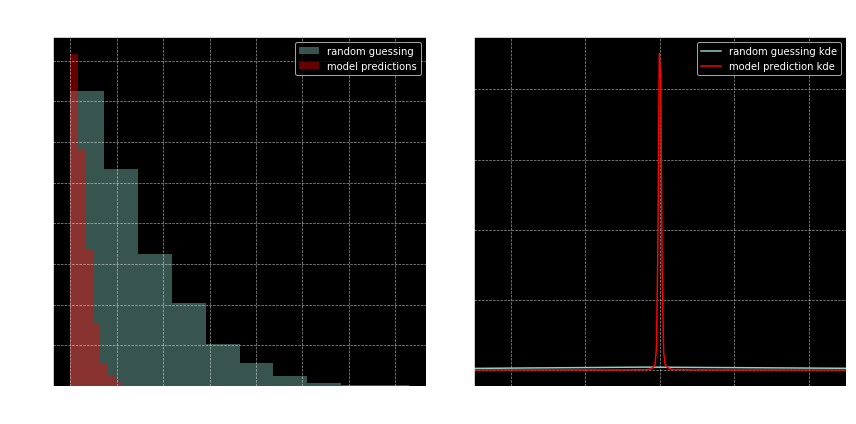

In [16]:
index = np.where(true_root_count == pred_root_count)[0]
index = np.random.choice(index, 1000, replace=False)

predicted_evals, random_evals = [], []
random_roots_list = []
predicted_roots_list = []
true_roots_list = []
for i in index:
    predicted_roots = [row[0] for row in y_pred[i] if row[1] < thr]
    true_roots = [row[0] for row in y_test[i] if row[1] == 0]
    random_roots = np.random.uniform(MIN_ROOT, MAX_ROOT, len(predicted_roots))
    random_roots = sorted(random_roots)
    random_roots_list.extend(random_roots)
    predicted_roots_list.extend(predicted_roots)
    true_roots_list.extend(true_roots)
    for predicted_root, random_root in zip(predicted_roots, random_roots):
        predicted_evals.append(
            np.polyval(X_test[i], predicted_root))
        random_evals.append(
            np.polyval(X_test[i], random_root))
        
assert len(true_roots_list) == len(predicted_roots_list)
assert len(random_roots_list) == len(predicted_roots_list)
true_roots_list = np.array(true_roots_list)
random_roots_list = np.array(random_roots_list)
predicted_roots_list = np.array(predicted_roots_list)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
ax.hist(np.abs(random_roots_list - true_roots_list),
        alpha=.4, label='random guessing') 
ax.hist(np.abs(predicted_roots_list - true_roots_list),
        color='r', alpha=.4, label='model predictions')
ax.set(title='Histogram of absolute errors',
       ylabel='count', xlabel='absolute error')
ax.legend(loc='best')

ax = axes[1]
pd.Series(random_evals).plot.kde(ax=ax, label='random guessing kde')
pd.Series(predicted_evals).plot.kde(ax=ax, color='r', label='model prediction kde')
title = 'Kernel Density Estimate plot\n' \
        'for polynomial evaluation of (predicted) roots'
ax.set(xlim=[-.5, .5], title=title)
ax.legend(loc='best')

fig.tight_layout()

Nice.